In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('./src') 
from xgboost_utils import train_xgb
from xgboost_predictor import generate_sparse_pgv  
from plot_utils import plot_pgv_example
import matplotlib.pyplot as plt

## Results at a Glance

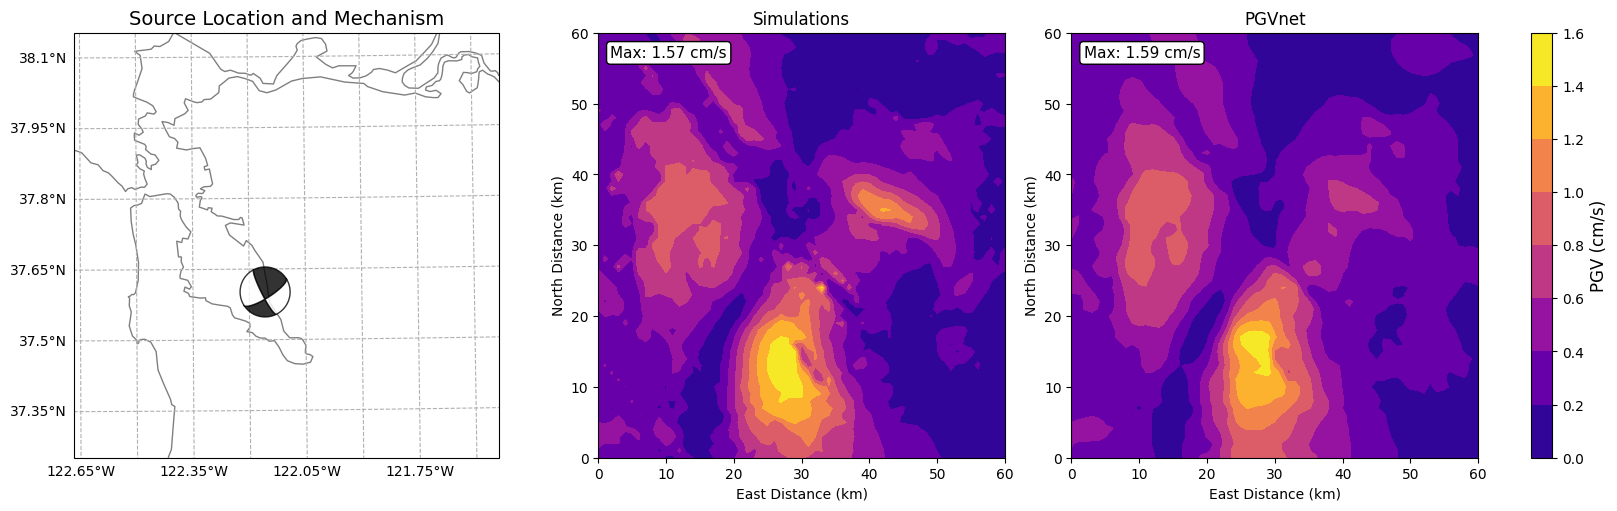

In [7]:
# choose a results directory and example index to plot (0-500)
results_dir = "results/test_hold0"  
example_idx = 1
fig = plot_pgv_example(results_dir, idx=example_idx)

We next demonstrate how to run each step in the framework:
###  Step 1: Train XGBoost Models and Generate Sparse Maps

1- We train one XGBoost model per receiver  


In [ ]:
# load input and output data for receiver
receiver_idx         = 139   # choose a receiver index from 0 to 255
receiver_database    = np.load(f'data/reciprocal_db/receiver_{receiver_idx}_database.npz')
inputs  = receiver_database['inputs']   # source coords and mechanism ([distance, azimuth, depth, strike, dip, rake, radiation, takeoff] )
outputs = receiver_database['outputs']  # pgv along two components (East-West, North-South) in mm/s

# train xgboost model 
pgv_true, pgv_pred = train_xgb(inputs, np.log(outputs[:,0]))  
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(pgv_true, pgv_pred)
ax.plot([-2, 7], [-2, 7], 'k--')
ax.set_xlabel('True log(PGV) (mm/s)')
ax.set_ylabel('Predicted log(PGV) (mm/s)')

2- We repeat the process above for all the receivers. The trained models for each receiver 
and for each of the components (East and North) are stored in the `XGBmodels/` directory. 

3 - We use the trained XGBoost models to generate sparse PGV maps for the forward simulations (used as input for Step 2) 

In [ ]:
# generate a sparse PGV map for input source coordinates and focal mechanism
# we show an example of generating sparse maps for a database with 100 source locations, and 50 mechanims per location refered to as 100_50

data_tag   = '100_50'  
models_dir = '/media/wolf6819/Elements/PGVnet/data/xgb_models'
spacing_km = 4 
station_coords_path = '/media/wolf6819/Elements/PGVnet/data/receiver_coords_sparse.npz' 
output_path         = 'data/step1_preds'

sparse_maps = generate_sparse_pgv(station_coords_path, models_dir, output_path, data_tag, spacing_km)

In [ ]:
# an example of a sparse PGV map  
station_coords_file = 'data/receiver_coords_sparse.npz'  
station_coords       = np.load(station_coords_file)['station_coords']

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(station_coords[:,0]/1e3, station_coords[:,1]/1e3, c = sparse_maps[0,:,:,0], s=100, cmap='plasma')
ax.set_xlabel('East Distance (km)') 
ax.set_ylabel('North Distance (km)')    

## Step 2: Train the Encoder-MLP on Sparse Maps

We use the predicted sparse maps to train an EncoderMLP network 


In [ ]:
from types import SimpleNamespace
from encoderMLP_predictor import run_train  

# Manual config 
config = SimpleNamespace(
  
    mode              = "train",
    data_tag          = "100_50_x4",
    downsample_factor = 4,
    
    # additional defaults 
    data_dir="data/",
    transform_input=True,
    transform_output=True,
    inc_gradient=False,
    inc_distance=True,
    normalize_output=True,
    normalize_input=True,
    nx_patch=8,
    ny_patch=8,
    fourier_features=False,
    D=32,
    gamma=5.0,
    n_samp_pts_per_patch=512,
    split=0.8,
    batch_size=32,
    learning_rate=1e-3,
    loss_type="mse",
    optimizer="adamw",
    num_epochs=50, 
    enc_type="edsr",
    in_channels=5,
    out_channels=32,
    conv_kernel_size=3,
    attention_kernel_size=1,
    num_features=32,
    num_blocks=8,
    nf=32,
    activation="leaky_relu",
    pad_size=4,
    sigma=3.0,
    results_dir=None,
    stats_tag='100_50_x4'
)

# Run training
run_train(config)


Next, we test the trained network on an independent set of test events, the results are stored in the relevant dir in the `./results` folder

In [ ]:
import yaml
from encoderMLP_predictor import run_inference, run_test
from types import SimpleNamespace

with open("results/test_hold0/config.yaml", "r") as f:
    
    cfg_dict = yaml.safe_load(f)

config             = SimpleNamespace(**cfg_dict)
config.mode        = "test"
config.results_dir = "results/test_hold0"

# Run testing
run_test(config)

We show an example of the true (simulated) vs predicted PGV maps 

In [ ]:
preds = np.load('results/test_hold0/test_preds.npy')
gts   = np.load('results/test_hold0/test_gts.npy')  

# choose a random idx between 0 and the number of samples in preds  
idx  = np.random.randint(0, preds.shape[0])
comp = 1  # choose component 0 (East-West) or 1 (North-South)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  
pred = preds[idx,:,:,comp]/10  # predicted PGV    
gt   = gts[idx,:,:,comp]/10    # true PGV
norm = plt.Normalize(vmin=0, vmax=np.max(gt)) 

cf0 = ax[0].contourf(gt, cmap='plasma', norm=norm)
cf1 = ax[1].contourf(pred, cmap='plasma', norm=norm)

ax[0].set_title('True PGV')    
ax[1].set_title('Predicted PGV')
ax[0].set_xlabel('East Distance (km)')  
ax[0].set_ylabel('North Distance (km)') 
ax[1].set_xlabel('East Distance (km)')  

fig.subplots_adjust(right=0.85)  
cbar_ax = fig.add_axes([0.88, 0.15, 0.02, 0.7]) 
fig.colorbar(cf1, cax=cbar_ax, norm = norm).set_label("PGV (cm/s)", fontsize=14)
# add text to both subplots with max pgv in each 
ax[0].text(0.05, 0.1, f'Max PGV: {np.max(gt):.2f} cm/s', transform=ax[0].transAxes,fontsize=12,verticalalignment='top',
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
ax[1].text(0.05, 0.1, f'Max PGV: {np.max(pred):.2f} cm/s', transform=ax[1].transAxes, fontsize=12, verticalalignment='top',
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# -------------------------
# Your house style (as given)
# -------------------------
mpl.rcParams['font.family'] = 'Nimbus Roman'  # Closest to Times New Roman
mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 14
mpl.rcParams['figure.figsize'] = (6, 4)
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['savefig.bbox'] = "tight"

import matplotlib.colors as mcolors

# -------------------------
# Settings
# -------------------------
holds = [0, 1, 2]          # which holds/runs to plot
n_bins = 6            # x-bins per subplot for mean lines
peak_q = 95                # None for raw max, or 95/99 for robust peak
peak_floor = 1e-3          # minimum allowed peak to avoid blow-ups
alpha_points = 0.22        # background scatter opacity
scatter_size = 26          # bigger points
x_margin_ratio = 0.06      # 6% margin around min/max to avoid clipping

# Colorblind-safe line colors for holds
hold_colors = ['#0072B2', '#D55E00', '#009E73']  # blue, vermillion, green

param_names = ["East Distance (km)", "North Distance (km)", "Depth (km)",
               "Strike (°)", "Dip (°)", "Rake (°)"]

# -------------------------
# Metric: MAE normalized by peak (per sample), reported in %
# -------------------------
def get_norm_mae_max_percent(preds, gts, q=95, floor=1e-3):
    """
    Normalized MAE (%) per sample.
    numerator: per-sample MAE over spatial dims
    denominator: per-sample peak scale of |gts|
      - q=None  -> raw max(|gts|)
      - q=95/99 -> robust peak = qth percentile of |gts|
    floor: minimum allowed peak to avoid blow-ups
    """
    abs_err = np.abs(preds - gts)
    mae = np.mean(abs_err, axis=(1, 2, 3))  # per-sample MAE

    mag = np.abs(gts).reshape(gts.shape[0], -1)
    if q is None:
        peak = np.max(mag, axis=1)
    else:
        peak = np.percentile(mag, q, axis=1)

    denom = np.maximum(peak, floor)
    return 100.0 * (mae / denom)  # percent

# -------------------------
# Data
# -------------------------
source_params = np.load('data/forward_db/source_params_100_50.npz')['source_params']
src_km = source_params.copy()
src_km[:, 0:3] /= 1000.0  # East/North/Depth to km

# -------------------------
# Figure setup
# -------------------------
fig, axes = plt.subplots(2, 3, figsize=(12, 7.5), sharey=True)
flat_axes = axes.flatten()
all_x = [list() for _ in range(6)]  # collect for global x-lims per panel

# Helper: minimal clean look
def prettify_axis(ax):
    ax.grid(True, linestyle='--', alpha=0.35)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='both', direction='out')

# -------------------------
# Pass 1: background scatter in black (all holds)
# -------------------------
for i in holds:
    gts   = np.load(f'results/test_hold{i}/test_gts.npy')
    preds = np.load(f'results/test_hold{i}/test_preds.npy')
    test_ids = np.load(f'results/test_hold{i}/test_ids.npy')

    y = get_norm_mae_max_percent(preds, gts, q=peak_q, floor=peak_floor)  # percent
    X = src_km[test_ids]  # (N, D)

    for d, ax in enumerate(flat_axes):
        if d >= X.shape[1]:
            ax.axis('off'); continue
        x = X[:, d]
        ax.scatter(x, y, s=scatter_size, c='k', alpha=alpha_points, linewidths=0, zorder=1)
        all_x[d].append(x)

# Consistent, wider x-lims/labels/grid (no clipping)
for d, ax in enumerate(flat_axes):
    if not ax.has_data():
        ax.axis('off')
        continue
    xcat = np.concatenate(all_x[d])
    xmin, xmax = np.nanmin(xcat), np.nanmax(xcat)
    # Optional clamp for East/North; otherwise use data min/max
    if d in (0, 1):
        xmin, xmax = min(xmin, -25), max(xmax, 25)
    # Add margin
    span = xmax - xmin if np.isfinite(xmax - xmin) and (xmax - xmin) > 0 else 1.0
    pad = span * x_margin_ratio
    ax.set_xlim(xmin - pad, xmax + pad)

    # Labels & style
    ax.set_xlabel(param_names[d])
    if d % 3 == 0:
        ax.set_ylabel("MAE / P95 (%)" if peak_q else "MAE / Peak (%)")
    ax.set_ylim(0, 15)
    prettify_axis(ax)

# -------------------------
# Pass 2: per-hold binned mean lines (optionally std ribbons)
# -------------------------
line_handles = []
for hi, i in enumerate(holds):
    gts   = np.load(f'results/test_hold{i}/test_gts.npy')
    preds = np.load(f'results/test_hold{i}/test_preds.npy')
    test_ids = np.load(f'results/test_hold{i}/test_ids.npy')

    y = get_norm_mae_max_percent(preds, gts, q=peak_q, floor=peak_floor)
    X = src_km[test_ids]

    for d, ax in enumerate(flat_axes):
        if d >= X.shape[1] or not ax.has_data():
            continue
        x = X[:, d]
        xmin, xmax = ax.get_xlim()
        edges = np.linspace(xmin, xmax, n_bins + 1)
        centers = 0.5 * (edges[:-1] + edges[1:])
        idx = np.digitize(x, edges) - 1

        means = np.full(n_bins, np.nan)
        stds  = np.full(n_bins, np.nan)
        for b in range(n_bins):
            mask = (idx == b) & np.isfinite(y)
            if np.any(mask):
                means[b] = y[mask].mean()
                stds[b]  = y[mask].std(ddof=1)

        ok = ~np.isnan(means)
        if np.any(ok):
            lh, = ax.plot(
                centers[ok], means[ok],
                linewidth=2.2, zorder=5,
                label=f"Test Hold {i}",
                color=hold_colors[hi % len(hold_colors)],
            )
            if d == 0:
                # collect a single handle per hold for a clean, global legend
                line_handles.append(lh)
            # Optional ribbons (commented to avoid clutter):
            # ax.fill_between(centers[ok], (means - stds)[ok], (means + stds)[ok],
            #                 alpha=0.12, zorder=4, color=hold_colors[hi % len(hold_colors)])

# -------------------------
# Context band: global mean ± std per panel (across all holds)
# -------------------------
for d, ax in enumerate(flat_axes):
    if not ax.has_data():
        continue
    ys = []
    for i in holds:
        gts   = np.load(f'results/test_hold{i}/test_gts.npy')
        preds = np.load(f'results/test_hold{i}/test_preds.npy')
        ys.append(get_norm_mae_max_percent(preds, gts, q=peak_q, floor=peak_floor))
    ycat = np.concatenate(ys)
    if np.any(np.isfinite(ycat)):
        gmean, gstd = np.mean(ycat), np.std(ycat, ddof=1)
        ax.axhspan(gmean - gstd, gmean + gstd, alpha=0.06, color='#999999', zorder=0)

# -------------------------
# Single, clean legend (bottom center), no title
# -------------------------
if line_handles:
    fig.legend(
        handles=line_handles,
        labels=[lh.get_label() for lh in line_handles],
        loc='lower center',
        ncol=len(line_handles),
        frameon=False,
        bbox_to_anchor=(0.5, -0.01),
        handlelength=2.0,
        handletextpad=0.6,
        borderpad=0.2
    )

# Tight layout for paper; no suptitle
fig.tight_layout(rect=[0, 0.03, 1, 1])
#plt.savefig("normalized_mae_by_p95_vs_params.png", dpi = 300)  # optional
# plt.show()


In [ ]:
import numpy as np

holds = [0]

per_hold_mae = []
per_hold_std = []        
total_abs_error = 0.0
total_count = 0

for i in holds:
    gts   = np.load(f"results/test_hold{i}/test_gts.npy")
    preds = np.load(f"results/test_hold{i}/test_preds.npy")
    err = np.abs(preds - gts).ravel()
    mae = err.mean()
    std = err.std(ddof=0)  # population std; use ddof=1 for sample std
    per_hold_mae.append(mae)
    per_hold_std.append(std)
    total_abs_error += err.sum()
    total_count += err.size
    print(f"Hold {i}: MAE = {mae:.6f}, STD = {std:.6f}  (n={err.size})")

per_hold_mae = np.array(per_hold_mae)
per_hold_std = np.array(per_hold_std)

macro_mae = per_hold_mae.mean()
macro_std = per_hold_mae.std(ddof=0)       # std of MAEs across holds
avg_hold_std = per_hold_std.mean()         # average per-hold std (what you asked for)
micro_mae = total_abs_error / total_count

print(f"\nMacro MAE (mean across holds): {macro_mae:.6f} ± {macro_std:.6f}")
print(f"Average per-hold STD (errors):  {avg_hold_std:.6f}")
print(f"Micro MAE (pooled across holds): {micro_mae:.6f}")
